# 1. Libraries

In [1]:
# To Extract Information from website:
from bs4 import BeautifulSoup
import urllib.request
import re

# To Import Latitude and Longitude information:
import geopy
from geopy.geocoders import Nominatim

# To work with FourSquare:
import requests
from pandas.io.json import json_normalize
from configparser import ConfigParser
from pathlib import Path

# Exploratory Data Analysis:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Feature Selection:
from sklearn.feature_selection import RFE, SelectFromModel
from boruta import BorutaPy

# To work with preditive models:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import lightgbm
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings

# 2. Importing Reference List

The following lists contains references of 2057 apartments from QuintoAndar website. Those references will be used to extract localization and features related to each apartment.

In [2]:
apes = pd.read_csv('apes.csv', header = None)
apes_2 = pd.read_csv('apes_2.csv', header = None)

In [3]:
apes.columns = ['site']
apes_2.columns = ['site']

In [4]:
apes = apes.drop_duplicates()
apes_2 = apes_2.drop_duplicates()

In [5]:
apes.head()

,site
0,/imovel/893099384?house_tags=newAd&search_rank...
1,/imovel/893098885?house_tags=newAd&search_rank...
2,/imovel/893098909?house_tags=newAd&search_rank...
3,/imovel/893099030?house_tags=newAd&search_rank...
4,/imovel/893099729?house_tags=newAd&search_rank...


# 3. Extracting info from WebSite

I will use BeautifulSoup library to extract information from QuintoAndar website. The information I need are divided into 3 different tables. Feature table contains Size, #Bedrooms, #Bathrooms, #Garage, Floor, the address table only contains the apartment address, the Price table contains Rent Price, Condo fee and Tax. In addition there are 2 different page layout at Quinto Andar, so I'll have to create a function that could extract info from both layouts.

In [6]:
def extract_info(url, info_list):
    '''This function receives a reference and a list and return this list filled with following apartment information:
    Address, Size, Number of Bedrooms, Number of Bathrooms, Garage, Floor, Is Pet Friendly, Have Furniture, 
    Is near subway, Tax, Condo Fee, Rental Price'''
    
    url_page = 'https://www.quintoandar.com.br'+url 
    page = urllib.request.urlopen(url_page)         
    soup = BeautifulSoup(page, 'html.parser')       
    
    try: 
        table_feature = soup.find('div', attrs={'class': 'sc-1yhpw8p-0 bJKAru'})
        features = table_feature.find_all('span', attrs = {'class': 'sc-bdVaJa eNFcTE'})
    except: 
        table_feature = soup.find('div', attrs={'class': 'sc-1yhpw8p-0 cdnOuv'})
        features = table_feature.find_all('span', attrs = {'class': 'sc-bdVaJa eNFcTE'})
              
    try: 
        size = re.findall('\d+', features[0].getText())
        size = int(size[0])
    except:
        pass
    
    try: 
        bed = re.findall('\d+', features[1].getText())
        bed = int(bed[0])
    except:
        bed = 'Error'
        
    try: 
        bath = re.findall('\d+', features[2].getText())
        bath = int(bath[0])
    except:
        bath = 'Error'
        
    try: 
        garage = re.findall('\d+', features[3].getText())
        garage = int(garage[0])
    except:
        garage = 0
        
    try: 
        floor = re.findall('\d+', features[4].getText())
        floor = int(floor[0])
    except:
        floor = 0
        
    pets = features[5].getText()
    furniture = features[6].getText()
    subway = features[7].getText()     
    
    
    try:
        table_address = soup.find('div', attrs={'class': 'sc-1p2ex32-0 e2tyeb-0 bQFede'})
        address = table_address.find_all('p', attrs = {'class': 'sc-bdVaJa gZyMJB'})
        address = address[0].getText()
    except:
        pass
    
    try:
        table_price = soup.find('ul', attrs = {'class': 'MuiList-root MuiList-padding'})
        rent_values = table_price.find_all('span', attrs = {'class': 'ek9a7p-0 djWxJW sc-11qijje-0 iRCHiJ'})
        other_values = table_price.find_all('span', attrs = {'class': 'ek9a7p-0 djWxJW sc-11qijje-0 bkKyCN'})
    except:
        table_price = soup.find('div', attrs = {'class': 'qp13xm-0 ddGxHx'})
        rent_values = table_price.find_all('span', attrs = {'class': 'ek9a7p-0 djWxJW sc-11qijje-0 iRCHiJ'})
        other_values = table_price.find_all('span', attrs = {'class': 'ek9a7p-0 djWxJW sc-11qijje-0 bkKyCN'})
       
    try:
        rent = re.findall('\d+', rent_values[0].getText())
        rent = int("".join(rent))
    except:
        rent = 'Error'
        
    try:
        condo_fee = re.findall('\d+', other_values[0].getText())
        condo_fee = int("".join(condo_fee))
    except:
        condo_fee = other_values[0].getText()
    try:
        tax = re.findall('\d+', other_values[1].getText())
        tax = int("".join(tax))
    except:
        tax = 'Error'
        
    try:
        info_list.append([address, size, bed, bath, garage, floor, pets, furniture, subway, condo_fee, tax, rent])
    except:
        pass
    
    return info_list

I'll use a for loop to extract information from all references contained at apes and apes_2

In [12]:
ap_info = []
for i in range(10):
    extract_info(apes_2.site[i], ap_info)

In [13]:
columns = ['Address', 'Size', 'Bedrooms', 'Bathrooms', 'Garage', 'Floor', 'Pet_Friendly', 'Furniture', 'Subway', 
           'Condo_Fee', 'Tax', 'Rent']

df = pd.DataFrame(ap_info, columns = columns)
df.head()

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,Tax,Rent
0,"Rua Ministro Nélson Hungria, Real Parque, São ...",50,1,1,1,5,Aceita pet,Mobiliado,Não próx.,800,142,2200
1,"Rua Ministro Nélson Hungria - Vila Tramontano,...",53,1,1,1,7,Aceita pet,Mobiliado,Não próx.,940,14,2200
2,"Rua Ministro Nelson Hungria, Real Parque, São ...",50,1,1,1,5,Não aceita,Mobiliado,Não próx.,682,111,1760
3,"Rua César Vallejo, Real Parque, São Paulo",43,1,1,1,9,Aceita pet,Sem mobília,Metrô próx.,0,0,2590
4,"Rua Barão Campos Gerais, Real Parque, São Paulo",108,2,3,1,7,Aceita pet,Sem mobília,Metrô próx.,1200,476,1931


# 4. Extracting Latitude and Longitude using Geopy

In [14]:
df = pd.read_csv('ape_preenchido.csv').drop('Unnamed: 0', axis = 1)
df.columns = ['Address', 'Size', 'Bedrooms', 'Bathrooms', 'Garage', 'Floor', 'Pet_Friendly', 'Furniture', 'Subway', 
              'Condo_Fee', 'Tax', 'Rent']
df.head()

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,Tax,Rent
0,"Rua Ministro Nélson Hungria, Real Parque, São ...",50,1,1,1,5,Aceita pet,Mobiliado,Não próx.,800,142,2200
1,"Rua Ministro Nélson Hungria, Real Parque, São ...",53,1,1,1,7,Aceita pet,Mobiliado,Não próx.,940,14,2200
2,"Rua Ministro Nelson Hungria, Real Parque, São ...",50,1,1,1,5,Não aceita,Mobiliado,Não próx.,682,111,1810
3,"Rua César Vallejo, Real Parque, São Paulo",43,1,1,1,9,Aceita pet,Sem mobília,Metrô próx.,0,0,2630
4,"Avenida Barão de Campos Gerais, Morumbi, São P...",108,2,3,1,7,Aceita pet,Sem mobília,Metrô próx.,1200,476,1931


In order to extract Latitude and Longitude of each address I'll use bellow function which will receive the address from previous DataFrame and using Geopy library will return a list with Latitude, Longitude, Street, City and Neighborhood.

In [16]:
def extract_location_info(address, address_info_list):
       
    geolocator = Nominatim(user_agent = 'Daniel_Mille')
    try:
        location = geolocator.geocode(address)
        if type(location) == geopy.location.Location:
            latitude = location.latitude
            longitude = location.longitude
            street = location.address.split(',')[0]
            city = location.address.split(',')[-4]
            neighborhood = location.address.split(',')[-5]
        else:
            latitude = -999
            longitude = -999
            street = address
            city = 'Error'
            neighborhood = 'Error'
        
    except:
        street = address
        city = 'Error time out'
        neighborhood = 'Error time out'
        latitude = 'Error time out'
        longitude = 'Error time out'
        
    address_info_list.append([address, street, neighborhood, city, latitude, longitude])
    
    return address_info_list

In [18]:
address_info = []
for i in range(10):
    extract_location_info(df.Address[i], address_info)

In [24]:
df_address = pd.DataFrame(address_info, columns = ['Address', 'Street', 'Neighborhood', 'City', 'Latitude', 
                                                   'Longitude']).drop_duplicates()

In [26]:
df_address.head()

,Address,Street,Neighborhood,City,Latitude,Longitude
0,"Rua Ministro Nélson Hungria, Real Parque, São ...",Rua Ministro Nelson Hungria,Carapicuíba,São Paulo,-23.572223,-46.825486
2,"Rua Ministro Nelson Hungria, Real Parque, São ...",Rua Ministro Nelson Hungria,Carapicuíba,São Paulo,-23.572223,-46.825486
3,"Rua César Vallejo, Real Parque, São Paulo",Rua César Vallejo,Morumbi,São Paulo,-23.606734,-46.701831
4,"Avenida Barão de Campos Gerais, Morumbi, São P...",Avenida Barão de Campos Gerais,Morumbi,São Paulo,-23.606269,-46.704536
7,"Rua Viena, Sacomã, São Paulo",Rua Viena,Sacomã,São Paulo,-23.613320,-46.599614


# 5. Extracting information of venues using FourSquare API

In [28]:
df = pd.read_csv('localization.csv').drop(['Unnamed: 0', 'Street'], axis = 1).drop_duplicates()
df.head()

,Address,Neighborhood,City,Latitude,Longitude
0,"Rua Ministro Nélson Hungria, Real Parque, São ...",Carapicuíba,São Paulo,-23.5722228,-46.8254858
1,"Rua Ministro Nélson Hungria, Real Parque, São ...",Error time out,Error time out,Error time out,Error time out
2,"Rua Ministro Nelson Hungria, Real Parque, São ...",Carapicuíba,São Paulo,-23.5722228,-46.8254858
3,"Rua César Vallejo, Real Parque, São Paulo",Morumbi,São Paulo,-23.6067336,-46.7018308
4,"Avenida Barão de Campos Gerais, Morumbi, São P...",Morumbi,São Paulo,-23.6062686,-46.7045358


In [29]:
df.Latitude = df.Latitude.replace('Error time out', np.nan)
df.Latitude = df.Latitude.replace('-999', np.nan)
df.Longitude = df.Longitude.replace('Error time out', np.nan)
df.Longitude = df.Longitude.replace('-999', np.nan)

df.Latitude = df.Latitude.astype(float)
df.Longitude = df.Longitude.astype(float)

In [30]:
df = df.dropna()

In [31]:
CLIENT_ID = 'JT2OYJNMGAGPDYQRZEBWHB4H54KL4DUWKW1UMLIBKXGWLYML' 
CLIENT_SECRET = 'NHICXGPPY5E0SMVYQP0L5MYDZI5CURJRUA1BLQM0310WSZP3'  
VERSION = '20200720'

I'll use the key categories from Four Square to group the Venues near to each apartment. A list with the major venues categories from Four Square can be seen below

In [32]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
category_results = requests.get(categories_url).json()
category_results = category_results['response']['categories']

In [33]:
categories = json_normalize(data=category_results)
categories = categories.drop(columns=['pluralName', 'shortName', 'categories', 'icon.prefix', 'icon.suffix'])
categories = categories.rename(columns={'id':'category_id', 'name':'category_name'})
categories

,category_id,category_name
0,4d4b7104d754a06370d81259,Arts & Entertainment
1,4d4b7105d754a06372d81259,College & University
2,4d4b7105d754a06373d81259,Event
3,4d4b7105d754a06374d81259,Food
4,4d4b7105d754a06376d81259,Nightlife Spot
5,4d4b7105d754a06377d81259,Outdoors & Recreation
6,4d4b7105d754a06375d81259,Professional & Other Places
7,4e67e38e036454776db1fb3a,Residence
8,4d4b7105d754a06378d81259,Shop & Service
9,4d4b7105d754a06379d81259,Travel & Transport


Function below will receive latitude, longitude, radius where we want to check for pins and category and will return how many pinned places were found near to lat and long informed.

In [34]:
def get_venues_total(lat, long, radius, category_id): 
    ''' Function which returns number of venues considering a Foursquare category and radius '''
    
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                      CLIENT_ID, 
                      CLIENT_SECRET, 
                      VERSION, 
                      lat,
                      long,
                      radius,
                      category_id)
  
    try:
        response = requests.get(explore_url).json()['response']['totalResults']
  
    except:
        response = 0
        
    return response

In [35]:
df.reset_index(inplace = True)

In [36]:
venues_list = []
for index in range(10):
    venues_list.append([df.Address[index], df.Latitude[index], df.Longitude[index]])
    for i in categories.category_id:
        venues_list[index].append(get_venues_total(lat = df.Latitude[index],
                                                   long = df.Longitude[index],
                                                   radius = 1000,
                                                   category_id = i))

In [38]:
df_filled = pd.DataFrame(venues_list, columns = ['Address', 'Latitude', 'Longitude', 'Entertainment', 
                                                 'College_University', 'Event', 'Food', 'NightLife', 'Recreation', 
                                                 'Professional_OtherPlaces', 'Residence', 'Shop_Service', 
                                                 'Travel_Transport'])
df_filled.head()

,Address,Latitude,Longitude,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
0,"Rua Ministro Nélson Hungria, Real Parque, São ...",-23.572223,-46.825486,3,4,0,9,6,4,6,3,5,2
1,"Rua Ministro Nelson Hungria, Real Parque, São ...",-23.572223,-46.825486,3,4,0,9,6,4,6,3,5,2
2,"Rua César Vallejo, Real Parque, São Paulo",-23.606734,-46.701831,8,29,9,87,18,41,74,17,75,34
3,"Avenida Barão de Campos Gerais, Morumbi, São P...",-23.606269,-46.704536,7,19,7,85,10,29,66,9,51,17
4,"Rua Viena, Sacomã, São Paulo",-23.613320,-46.599614,4,11,1,53,13,17,39,12,52,4


# 6. Exploratory Data Analysis

In [42]:
apes = pd.read_csv('ape_preenchido.csv').drop('Unnamed: 0', axis = 1)
localization = pd.read_csv('localization_filled.csv').drop('Unnamed: 0', axis = 1)
df = pd.merge(apes, localization, on = 'Address', how = 'left')
df.columns = ['Address', 'Size', 'Bedrooms', 'Bathrooms', 'Garage', 'Floor', 'Pet_Friendly', 'Furniture', 'Subway', 
              'Condo_Fee', 'Tax', 'Rent', 'Latitude', 'Longitude', 'Entertainment', 'College_University', 'Event',
              'Food', 'NightLife', 'Recreation', 'Professional_OtherPlaces', 'Residence', 'Shop_Service',
              'Travel_Transport']
df.head(2)

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
0,"Rua Ministro Nélson Hungria, Real Parque, São ...",50,1,1,1,5,Aceita pet,Mobiliado,Não próx.,800,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0
1,"Rua Ministro Nélson Hungria, Real Parque, São ...",53,1,1,1,7,Aceita pet,Mobiliado,Não próx.,940,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0


In [41]:
df[df.isnull().any(axis=1)].head()

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
48,"Praça Hilário da Conceição, Sítio do Mandaqui,...",49,2,1,1,6,Aceita pet,Mobiliado,Não próx.,400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,"Rua Epaminondas Melo do Amaral, Sítio do Manda...",55,2,1,1,0,Aceita pet,Sem mobília,Não próx.,650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,"Rua Epaminondas Melo do Amaral, Sítio do Manda...",59,2,1,1,6,Aceita pet,Sem mobília,Não próx.,600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,"Rua Leandro Dupret, Vila Clementino, São Paulo",45,1,1,1,17,Não aceita,Sem mobília,Metrô próx.,650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,"Rua Parambú, Jaçana, São Paulo",49,2,1,1,7,Aceita pet,Sem mobília,Não próx.,470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All streets above were not recognized by Geopy. Biggest part of the list are very short streets with no reference of latitude and longitude at Geopy and due to this reason will be dropped from DataFrame.

In [43]:
df.dropna(inplace = True)

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,1292.0,69.603715,46.885964,15.000000,46.750000,60.000000,74.000000,750.000000
Bedrooms,1292.0,1.875387,0.793534,1.000000,1.000000,2.000000,2.000000,5.000000
Bathrooms,1292.0,1.671827,0.846396,1.000000,1.000000,2.000000,2.000000,7.000000
Garage,1292.0,0.998452,0.760161,0.000000,1.000000,1.000000,1.000000,5.000000
Floor,1292.0,7.583591,5.766968,0.000000,3.000000,6.500000,11.000000,41.000000
Condo_Fee,1292.0,680.010836,498.288580,0.000000,430.000000,600.000000,800.000000,7000.000000
Tax,1292.0,134.513932,503.861858,0.000000,1.000000,74.500000,159.250000,17000.000000
Rent,1292.0,2729.758514,1799.941202,650.000000,1700.000000,2300.000000,3135.000000,15000.000000
Latitude,1292.0,-23.552100,0.142943,-24.155493,-23.584260,-23.554267,-23.533606,-20.287455
Longitude,1292.0,-46.649819,0.126241,-50.245971,-46.682484,-46.647022,-46.611239,-46.296690


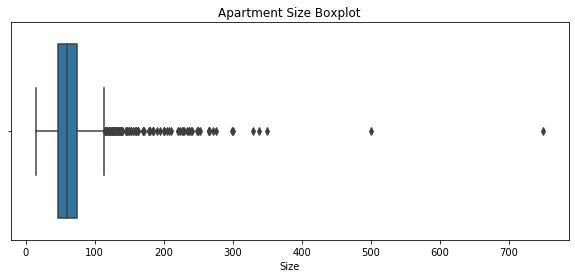

In [46]:
plt.figure(figsize = (10, 4))
sns.boxplot(df.Size)
plt.title('Apartment Size Boxplot');

In [47]:
df[df.Size > 400]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
648,"Rua Groenlândia, Jardim Paulista, São Paulo",750,5,7,0,0,Aceita pet,Sem mobília,Não próx.,0,...,12.0,30.0,5.0,134.0,23.0,45.0,105.0,9.0,46.0,31.0
754,"Praça da República, Republica, São Paulo",500,3,4,1,9,Aceita pet,Mobiliado,Metrô próx.,3200,...,63.0,54.0,11.0,201.0,107.0,92.0,98.0,31.0,118.0,99.0


Index 648 has 750m with no Condo_Fee, 0 Floor and no Garage, it is probably a house that was extract by mistake and will be deleted from the DataFrame

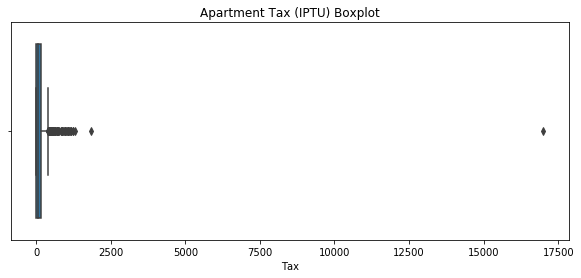

In [48]:
plt.figure(figsize = (10, 4))
sns.boxplot(df.Tax)
plt.title('Apartment Tax (IPTU) Boxplot');

In [49]:
df[df.Tax > 15000]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
808,"Rua Francisco Leitão, Pinheiros, São Paulo",44,1,2,0,5,Aceita pet,Sem mobília,Metrô próx.,640,...,66.0,47.0,3.0,206.0,101.0,58.0,75.0,25.0,100.0,33.0


In [50]:
df[df.Size < 50]['Tax'].mean()

105.33585858585859

An apartment with 44m2 with IPTU of 17k reais for sure is a typo. As informed above the mean IPTU for an apartment with less than 50m2 is 105 reais, so probably the IPTU for this apartment might be 170.

In [51]:
df.at[808, 'Tax'] = 170

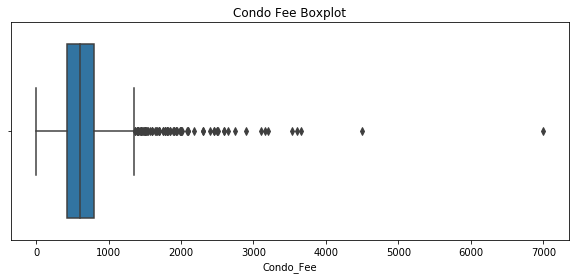

In [52]:
plt.figure(figsize = (10, 4))
sns.boxplot(df.Condo_Fee)
plt.title('Condo Fee Boxplot');

In [53]:
df[df.Condo_Fee > 3000]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
298,"Rua Padre Mário Fontana, Mooca, São Paulo",131,3,5,3,3,Aceita pet,Mobiliado,Metrô próx.,4500,...,6.0,23.0,3.0,101.0,11.0,38.0,53.0,9.0,82.0,11.0
591,"Rua Apinajés, Sumaré, São Paulo",226,4,3,0,16,Aceita pet,Mobiliado,Não próx.,3600,...,28.0,35.0,3.0,125.0,23.0,71.0,52.0,19.0,60.0,18.0
611,"Rua Padre João Manuel, Jardim Paulista, São Paulo",162,3,3,1,14,Aceita pet,Sem mobília,Metrô próx.,3100,...,57.0,46.0,5.0,244.0,101.0,84.0,108.0,27.0,124.0,82.0
639,"Rua Cristiano Viana, Pinheiros, São Paulo",248,3,4,4,2,Aceita pet,Sem mobília,Metrô próx.,3163,...,59.0,57.0,4.0,155.0,108.0,74.0,73.0,20.0,73.0,29.0
647,"Rua Bela Cintra, Jardim Paulista, São Paulo",200,3,3,2,3,Aceita pet,Mobiliado,Metrô próx.,3534,...,50.0,67.0,4.0,202.0,78.0,60.0,91.0,22.0,108.0,69.0
709,"Avenida Horácio Lafer, Itaim Bibi, São Paulo",178,3,4,2,1,Aceita pet,Sem mobília,Não próx.,3650,...,27.0,46.0,2.0,242.0,112.0,81.0,126.0,20.0,106.0,47.0
754,"Praça da República, Republica, São Paulo",500,3,4,1,9,Aceita pet,Mobiliado,Metrô próx.,3200,...,63.0,54.0,11.0,201.0,107.0,92.0,98.0,31.0,118.0,99.0
1044,"Rua Minas Gerais, Higienópolis, São Paulo",300,2,3,2,1,Aceita pet,Sem mobília,Metrô próx.,7000,...,2.0,7.0,0.0,28.0,4.0,5.0,14.0,4.0,12.0,5.0


In [54]:
df.loc[298]

Address                     Rua Padre Mário Fontana, Mooca, São Paulo
Size                                                              131
Bedrooms                                                            3
Bathrooms                                                           5
Garage                                                              3
Floor                                                               3
Pet_Friendly                                               Aceita pet
Furniture                                                   Mobiliado
Subway                                                    Metrô próx.
Condo_Fee                                                        4500
Tax                                                               100
Rent                                                             2639
Latitude                                                     -23.5795
Longitude                                                    -46.5894
Entertainment       

Probably this is another typo and the condo fee value should be 450 instead of 4500.

In [55]:
df.at[298, 'Condo_Fee'] = 450

In [56]:
df.loc[1044]

Address                     Rua Minas Gerais, Higienópolis, São Paulo
Size                                                              300
Bedrooms                                                            2
Bathrooms                                                           3
Garage                                                              2
Floor                                                               1
Pet_Friendly                                               Aceita pet
Furniture                                                 Sem mobília
Subway                                                    Metrô próx.
Condo_Fee                                                        7000
Tax                                                              1834
Rent                                                             1987
Latitude                                                     -20.2875
Longitude                                                     -50.246
Entertainment       

In the case of index 1044 the values of Rent and Condo fee are switched.

In [57]:
df.at[1044, 'Condo_Fee'] = 1987
df.at[1044, 'Rent'] = 7000

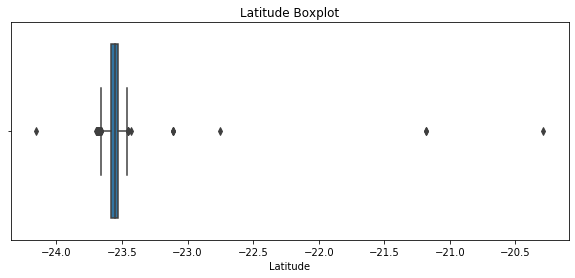

In [58]:
plt.figure(figsize = (10, 4))
sns.boxplot(df.Latitude)
plt.title('Latitude Boxplot');

In [59]:
df[(df.Latitude > -23.4) | (df.Latitude < -23.7)].head()

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
409,"Avenida Ipiranga 1284, Centro, São Paulo",38,1,1,0,9,Aceita pet,Sem mobília,Metrô próx.,460,...,1.0,0.0,0.0,4.0,0.0,3.0,1.0,0.0,4.0,3.0
433,"Rua Abolição, Bela Vista, São Paulo",60,2,1,1,5,Aceita pet,Mobiliado,Metrô próx.,685,...,2.0,18.0,1.0,69.0,15.0,16.0,46.0,5.0,35.0,6.0
570,"Avenida São João, Centro, São Paulo",100,2,2,0,5,Não aceita,Sem mobília,Metrô próx.,0,...,3.0,7.0,0.0,27.0,4.0,12.0,33.0,0.0,38.0,5.0
625,"Avenida São João, Centro, São Paulo",46,1,1,0,4,Não aceita,Sem mobília,Metrô próx.,500,...,3.0,7.0,0.0,27.0,4.0,12.0,33.0,0.0,38.0,5.0
748,"Rua Vitória, Centro, São Paulo",30,1,1,0,4,Aceita pet,Sem mobília,Metrô próx.,250,...,9.0,13.0,0.0,49.0,9.0,14.0,31.0,1.0,20.0,11.0


In [61]:
geolocator = Nominatim(user_agent = 'Daniel_Mille')
location = geolocator.geocode(df.loc[409]['Address'])
location.address

'Avenida Ipiranga, Suarão, Itanhaém, Região Imediata de Santos, Região Metropolitana da Baixada Santista, São Paulo, Região Sudeste, Brasil'

In [62]:
location = geolocator.geocode(df.loc[433]['Address'])
location.address

'Rua Abolição, Jardim Colina, Jardim São Paulo, Americana, Região Imediata de Campinas, Região Metropolitana de Campinas, Região Geográfica Intermediária de Campinas, São Paulo, Região Sudeste, 13468-080, Brasil'

In [63]:
location = geolocator.geocode(df.loc[196]['Address'])
location.address

'Avenida Engenheiro José Salles, Condomínio Conjunto Residencial Parque dos Pássaros II, Socorro, São Paulo, Região Sudeste, 04777-140, Brasil'

For all Latitude outliers Geopy recognized the same street name at another city in São Paulo, and for these reason, those rows will be removed from DataFrame

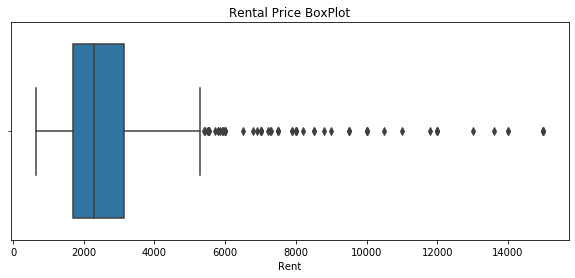

In [64]:
plt.figure(figsize = (10, 4))
sns.boxplot(df.Rent)
plt.title('Rental Price BoxPlot');

In [65]:
df[df.Rent > 7500]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
290,"Rua Airosa Galvão, Perdizes, São Paulo",178,4,5,4,4,Aceita pet,Sem mobília,Metrô próx.,1900,...,38.0,28.0,9.0,188.0,51.0,59.0,78.0,18.0,104.0,47.0
343,"Rua Pablo Picasso, Barra Funda, São Paulo",241,4,5,0,16,Aceita pet,Sem mobília,Metrô próx.,1700,...,14.0,13.0,1.0,60.0,23.0,32.0,38.0,16.0,65.0,12.0
351,"Rua Casa Forte, Água Fria, São Paulo",272,4,4,0,15,Aceita pet,Sem mobília,Não próx.,2900,...,2.0,10.0,3.0,89.0,7.0,28.0,46.0,6.0,57.0,6.0
417,"Rua Santo Antônio, Bela Vista, São Paulo",50,1,1,1,2,Não aceita,Mobiliado,Metrô próx.,632,...,87.0,58.0,9.0,228.0,132.0,72.0,90.0,43.0,112.0,84.0
486,"Rua São Carlos do Pinhal, Bela Vista, São Paulo",180,3,4,2,1,Não aceita,Mobiliado,Metrô próx.,1600,...,61.0,47.0,6.0,242.0,133.0,75.0,146.0,40.0,134.0,88.0
559,"Rua Otávio Nébias, Paraíso, São Paulo",190,3,3,2,3,Não aceita,Sem mobília,Metrô próx.,2500,...,25.0,57.0,6.0,152.0,47.0,82.0,131.0,34.0,116.0,72.0
587,"Rua Martiniano de Carvalho, Bela Vista, São Paulo",140,3,5,2,20,Aceita pet,Mobiliado,Metrô próx.,1450,...,36.0,65.0,4.0,219.0,68.0,61.0,139.0,31.0,109.0,73.0
591,"Rua Apinajés, Sumaré, São Paulo",226,4,3,0,16,Aceita pet,Mobiliado,Não próx.,3600,...,28.0,35.0,3.0,125.0,23.0,71.0,52.0,19.0,60.0,18.0
595,"Alameda Santos, Jardim Paulista, São Paulo",250,3,3,1,9,Aceita pet,Sem mobília,Metrô próx.,1846,...,39.0,47.0,6.0,206.0,124.0,60.0,115.0,20.0,110.0,74.0
639,"Rua Cristiano Viana, Pinheiros, São Paulo",248,3,4,4,2,Aceita pet,Sem mobília,Metrô próx.,3163,...,59.0,57.0,4.0,155.0,108.0,74.0,73.0,20.0,73.0,29.0


In [66]:
df.loc[417]

Address                     Rua Santo Antônio, Bela Vista, São Paulo
Size                                                              50
Bedrooms                                                           1
Bathrooms                                                          1
Garage                                                             1
Floor                                                              2
Pet_Friendly                                              Não aceita
Furniture                                                  Mobiliado
Subway                                                   Metrô próx.
Condo_Fee                                                        632
Tax                                                                0
Rent                                                            8000
Latitude                                                    -23.5521
Longitude                                                   -46.6458
Entertainment                     

This is another typo, and the rental price should be 800 instead of 8000

In [67]:
df.at[417, 'Rent'] = 800

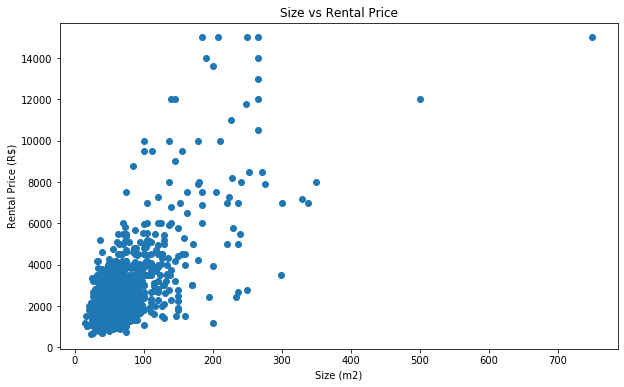

In [68]:
plt.figure(figsize = (10, 6))
plt.scatter(df.Size, df.Rent)
plt.title('Size vs Rental Price')
plt.xlabel('Size (m2)')
plt.ylabel('Rental Price (R$)');

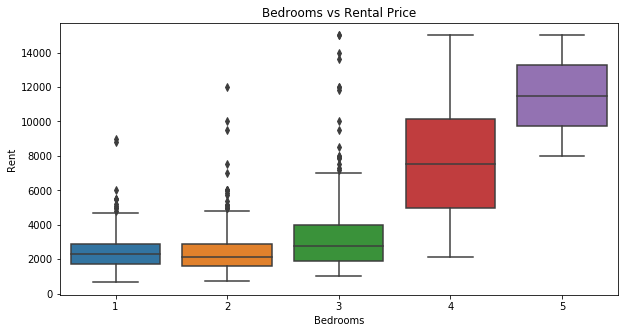

In [69]:
plt.figure(figsize = (10, 5))
sns.boxplot(df.Bedrooms, df.Rent)
plt.title('Bedrooms vs Rental Price');

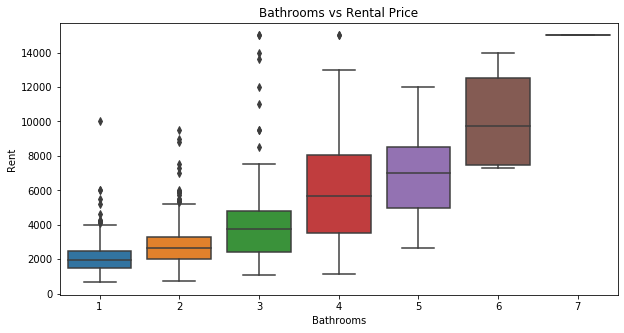

In [70]:
plt.figure(figsize = (10, 5))
sns.boxplot(df.Bathrooms, df.Rent)
plt.title('Bathrooms vs Rental Price');

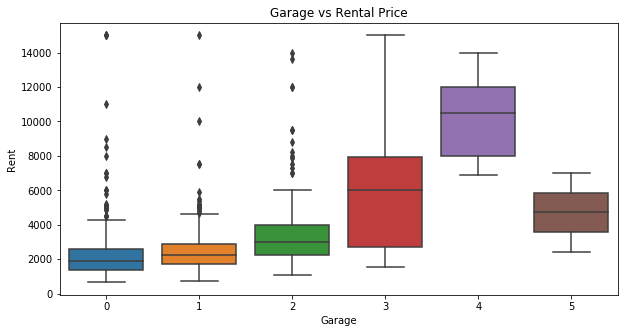

In [71]:
plt.figure(figsize = (10, 5))
sns.boxplot(df.Garage, df.Rent)
plt.title('Garage vs Rental Price');

In [72]:
df[df.Garage == 5]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
353,"Rua Doutor Guilherme Cristofel, Santana, São P...",236,4,5,5,8,Aceita pet,Sem mobília,Não próx.,2300,...,6.0,17.0,2.0,94.0,21.0,38.0,51.0,11.0,53.0,2.0
755,"Avenida Casa Verde, Casa Verde, São Paulo",195,3,2,5,0,Aceita pet,Sem mobília,Não próx.,0,...,8.0,14.0,1.0,85.0,8.0,30.0,51.0,10.0,67.0,3.0


Index 755 is probably another house choosen by mistake. Does not have condo fee information, and floor is zero.

In [73]:
df[(df.Garage == 0) & (df.Rent > 6000)]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
343,"Rua Pablo Picasso, Barra Funda, São Paulo",241,4,5,0,16,Aceita pet,Sem mobília,Metrô próx.,1700,...,14.0,13.0,1.0,60.0,23.0,32.0,38.0,16.0,65.0,12.0
351,"Rua Casa Forte, Água Fria, São Paulo",272,4,4,0,15,Aceita pet,Sem mobília,Não próx.,2900,...,2.0,10.0,3.0,89.0,7.0,28.0,46.0,6.0,57.0,6.0
575,"Rua João Ramalho, Perdizes, São Paulo",140,4,3,0,12,Aceita pet,Sem mobília,Não próx.,1600,...,21.0,36.0,3.0,143.0,25.0,48.0,74.0,19.0,90.0,17.0
591,"Rua Apinajés, Sumaré, São Paulo",226,4,3,0,16,Aceita pet,Mobiliado,Não próx.,3600,...,28.0,35.0,3.0,125.0,23.0,71.0,52.0,19.0,60.0,18.0
648,"Rua Groenlândia, Jardim Paulista, São Paulo",750,5,7,0,0,Aceita pet,Sem mobília,Não próx.,0,...,12.0,30.0,5.0,134.0,23.0,45.0,105.0,9.0,46.0,31.0
749,"Rua da Consolação, Jardim Paulista, São Paulo",105,3,3,0,25,Aceita pet,Mobiliado,Metrô próx.,900,...,39.0,50.0,5.0,210.0,122.0,60.0,113.0,19.0,109.0,73.0
771,"Avenida Paulista, Consolação, São Paulo",145,1,2,0,8,Aceita pet,Sem mobília,Metrô próx.,340,...,53.0,50.0,7.0,155.0,109.0,67.0,147.0,33.0,103.0,81.0
811,"Rua Engenheiro Sá Rocha, Alto de Pinheiros, Sã...",220,3,2,0,0,Aceita pet,Sem mobília,Não próx.,0,...,6.0,11.0,2.0,45.0,7.0,39.0,52.0,7.0,50.0,4.0
968,"Rua Gabriele D'annunzio, Campo Belo, São Paulo",185,3,3,0,10,Aceita pet,Mobiliado,Metrô próx.,1900,...,8.0,34.0,3.0,158.0,16.0,49.0,76.0,43.0,89.0,21.0
1254,"Rua Professor Campos de Oliveira, Jardim Maraj...",266,4,4,0,15,Aceita pet,Mobiliado,Não próx.,2650,...,1.0,36.0,1.0,63.0,4.0,31.0,41.0,17.0,47.0,5.0


Probably during feature extraction there was an error trying to extract garage information for those apartments. Garage will be replaced by median value for those apartments

In [75]:
df[df.Rent>8000]['Garage'].median()

2.0

In [76]:
df.at[343, 'Garage'] = 2
df.at[575, 'Garage'] = 2
df.at[749, 'Garage'] = 2
df.at[351, 'Garage'] = 2
df.at[591, 'Garage'] = 2
df.at[771, 'Garage'] = 2
df.at[968, 'Garage'] = 2
df.at[1254, 'Garage'] = 2

In [77]:
df[df.Floor == 0]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
25,"Rua Duarte de Azevedo, Santana, São Paulo",44,1,1,1,0,Aceita pet,Mobiliado,Metrô próx.,600,...,13.0,33.0,1.0,104.0,20.0,34.0,62.0,7.0,67.0,23.0
128,"Avenida General Penha Brasil, Brasilandia, São...",48,2,1,0,0,Aceita pet,Sem mobília,Não próx.,100,...,1.0,2.0,0.0,14.0,9.0,6.0,11.0,1.0,17.0,2.0
143,"Rua Paulo Bender, São Lucas, São Paulo",71,1,1,1,0,Aceita pet,Sem mobília,Metrô próx.,0,...,11.0,6.0,1.0,42.0,4.0,17.0,26.0,14.0,46.0,4.0
206,"Rua Rodesia, Vila Madalena, São Paulo",74,1,2,2,0,Aceita pet,Sem mobília,Metrô próx.,900,...,63.0,38.0,5.0,161.0,149.0,65.0,61.0,12.0,79.0,25.0
293,"Rua Aimberê, Perdizes, São Paulo",80,2,1,0,0,Aceita pet,Sem mobília,Não próx.,442,...,39.0,46.0,4.0,189.0,63.0,62.0,67.0,17.0,106.0,18.0
349,"Rua Outeiro da Cruz, Santana, São Paulo",70,2,1,0,0,Aceita pet,Sem mobília,Metrô próx.,330,...,8.0,11.0,5.0,109.0,31.0,38.0,53.0,10.0,57.0,7.0
361,"Rua Bela Cintra, Consolação, São Paulo",42,1,1,1,0,Não aceita,Mobiliado,Metrô próx.,660,...,45.0,38.0,7.0,185.0,104.0,63.0,130.0,27.0,99.0,83.0
399,"Rua Mazzini, Aclimação, São Paulo",85,1,2,1,0,Não aceita,Sem mobília,Não próx.,720,...,11.0,24.0,6.0,97.0,9.0,36.0,41.0,27.0,52.0,9.0
462,"Rua Santo Amaro, Bela Vista, São Paulo",40,1,1,1,0,Aceita pet,Mobiliado,Metrô próx.,422,...,70.0,52.0,7.0,206.0,106.0,69.0,86.0,23.0,104.0,69.0
536,"Rua Campevas, Sumaré, São Paulo",50,1,1,0,0,Aceita pet,Sem mobília,Não próx.,200,...,27.0,50.0,3.0,189.0,35.0,56.0,56.0,22.0,84.0,14.0


In [78]:
df.drop([409, 433, 570, 578, 625, 648, 657, 697, 700, 712, 725, 738, 748, 751, 755, 786, 811, 813, 817, 834, 838, 
         848, 1044, 1107, 1136], axis = 0, inplace = True)

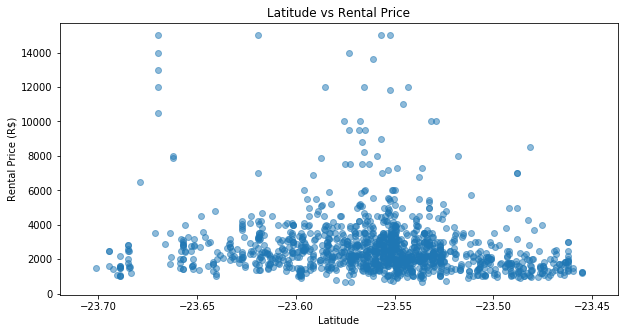

In [79]:
plt.figure(figsize = (10, 5))
plt.scatter(df.Latitude, df.Rent, alpha = 0.5)
plt.title('Latitude vs Rental Price')
plt.xlabel('Latitude')
plt.ylabel('Rental Price (R$)');

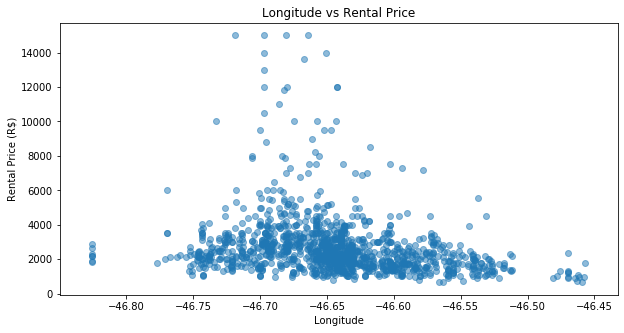

In [80]:
plt.figure(figsize = (10, 5))
plt.scatter(df.Longitude, df.Rent, alpha = 0.5)
plt.title('Longitude vs Rental Price')
plt.xlabel('Longitude')
plt.ylabel('Rental Price (R$)');

In [81]:
df[(df.Longitude > -46.4) | (df.Longitude < -46.8)]

,Address,Size,Bedrooms,Bathrooms,Garage,Floor,Pet_Friendly,Furniture,Subway,Condo_Fee,...,Entertainment,College_University,Event,Food,NightLife,Recreation,Professional_OtherPlaces,Residence,Shop_Service,Travel_Transport
0,"Rua Ministro Nélson Hungria, Real Parque, São ...",50,1,1,1,5,Aceita pet,Mobiliado,Não próx.,800,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0
1,"Rua Ministro Nélson Hungria, Real Parque, São ...",53,1,1,1,7,Aceita pet,Mobiliado,Não próx.,940,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0
2,"Rua Ministro Nelson Hungria, Real Parque, São ...",50,1,1,1,5,Não aceita,Mobiliado,Não próx.,682,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0
5,"Rua Ministro Nélson Hungria, Real Parque, São ...",43,1,1,1,7,Não aceita,Mobiliado,Não próx.,850,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0
1057,"Rua Ministro Nelson Hungria, Real Parque, São ...",46,1,1,1,6,Aceita pet,Mobiliado,Não próx.,722,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0
1059,"Rua Ministro Nélson Hungria, Real Parque, São ...",45,1,1,1,3,Aceita pet,Mobiliado,Não próx.,740,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0
1062,"Rua Ministro Nélson Hungria, Real Parque, São ...",49,1,1,1,7,Aceita pet,Mobiliado,Não próx.,830,...,3.0,4.0,0.0,9.0,6.0,4.0,6.0,3.0,5.0,2.0


In [82]:
geolocator = Nominatim(user_agent = 'Daniel_Mille')
location = geolocator.geocode(df.loc[0]['Address'])
location.address

'Rua Ministro Nelson Hungria, Parque Santa Tereza, Aldeira de Carapicuíba, Carapicuíba, São Paulo, Região Sudeste, 06333-230, Brasil'

More apartments out of São Paulo due to wrong information from Geopy.

In [83]:
df.drop([0, 1, 2, 5, 1057, 1059, 1062], axis = 0, inplace = True)

### 6.1 - Pre-processing categorical features

In [85]:
df.Pet_Friendly = df.Pet_Friendly.apply(lambda x: 1 if x == 'Aceita pet' else 0)
df.Furniture = df.Furniture.apply(lambda x: 1 if x == 'Mobiliado' else 0)
df.Subway = df.Subway.apply(lambda x: 1 if x == 'Metrô próx.' else 0)

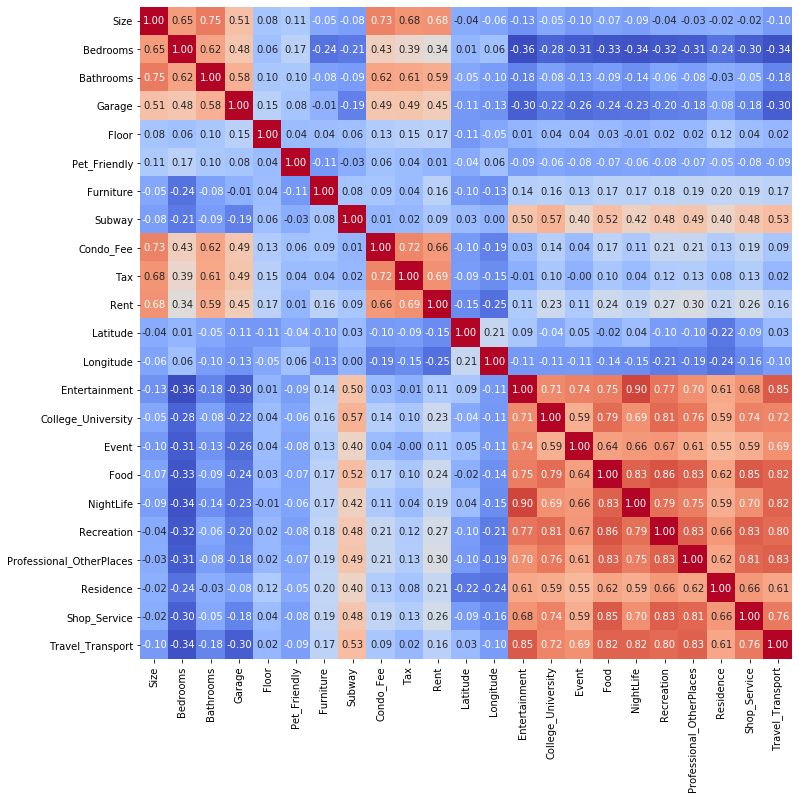

In [89]:
plt.figure(figsize = (12,12))
sns.heatmap(df.corr(), cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap='coolwarm')

Due to high correlation on Venues, I'll group them in 3 new categories

In [90]:
df['Entert_Venues'] = df['Entertainment'] + df['Event'] + df['NightLife']
df['Key_Venues'] = df['College_University'] + df['Shop_Service'] + df['Professional_OtherPlaces']

In [91]:
df.drop(['College_University', 'Shop_Service', 'Professional_OtherPlaces', 'Entertainment', 'Event', 'NightLife', 
         'Residence', 'Travel_Transport'], axis = 1, inplace = True)

# 7. Feature Selection

In [92]:
X = df.drop(['Address', 'Rent'], axis = 1)
y = df.Rent

minmax = MinMaxScaler()

X.loc[:,:] = minmax.fit_transform(X.loc[:,:])

In [94]:
rfe_selector = RFE(estimator = LinearRegression(), n_features_to_select = 8, step = 10, verbose = 5)
rfe_selector.fit(X, y)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
rfe_feature

Fitting estimator with 16 features.


['Size',
 'Bathrooms',
 'Garage',
 'Floor',
 'Condo_Fee',
 'Tax',
 'Longitude',
 'Key_Venues']

In [95]:
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=100), max_features=10)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
embeded_rf_feature

['Size', 'Condo_Fee', 'Tax', 'Longitude']

In [96]:
X_boruta = X.to_numpy()
y_boruta = y.to_numpy()

forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)


boruta_selector = BorutaPy(forest, n_estimators = 'auto', random_state = 11)
boruta_selector.fit(X_boruta, y_boruta)

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=5,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=89, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x14bc5bea0>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_

In [97]:
green_area = X.columns[boruta_selector.support_].to_list()
blue_area = X.columns[boruta_selector.support_weak_].to_list()
print(green_area + blue_area, end = " ")

['Size', 'Bathrooms', 'Condo_Fee', 'Tax', 'Longitude', 'Recreation', 'Entert_Venues', 'Key_Venues', 'Latitude'] 

Based on feature selection models and Correlation matrix I'll use following features:

In [98]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 11)
df_train = df_train.copy().drop('Address', axis = 1)
df_test = df_test.copy().drop('Address', axis = 1)

X_train = df_train[['Size','Bathrooms', 'Condo_Fee', 'Tax', 'Longitude', 'Recreation', 'Key_Venues','Entert_Venues']]
y_train = df_train.Rent
X_test = df_test[['Size','Bathrooms', 'Condo_Fee', 'Tax', 'Longitude', 'Recreation', 'Key_Venues','Entert_Venues']]
y_test = df_test.Rent

# 8. Machine Learning models

In [100]:
minmax = MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

## 8.1 - Linear Regression

In [102]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
y_pred = lr.predict(X_test)
Results = {}
Results['Linear_Regression'] = [r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred)]
print(f'R2 for Linear Regression is: {r2_score(y_test, y_pred):.2}')
print(f'MAE for Linear Regression is: {mean_absolute_error(y_test, y_pred):.5}')

R2 for Linear Regression is: 0.63
MAE for Linear Regression is: 771.08


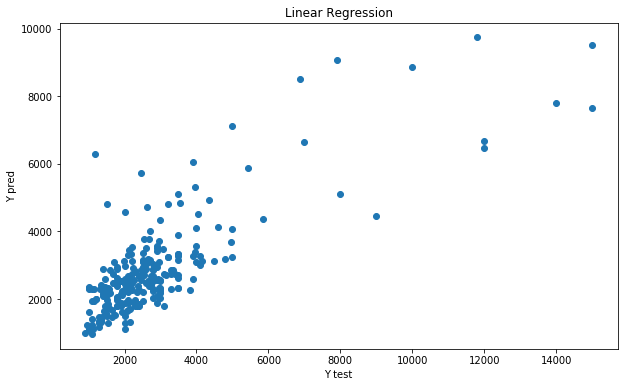

In [104]:
plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_pred)
plt.title('Linear Regression')
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.show()

## 8.2 - Decision Tree Regressor

In [105]:
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

tree = DecisionTreeRegressor(random_state = 11)

param_space = {'max_depth': Integer(1, 20),
               'min_samples_split': Real(0.0001, 0.3)}

bayes_tree = BayesSearchCV(estimator = tree,
                           search_spaces = param_space,
                           n_iter = 150,
                           cv = 3,
                           random_state = 11)

bayes_tree.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=11,
                                              splitter='best'),
              fit_params=None, iid=True, n_iter=150, n_jobs=1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=11,
              refit=True, retur

In [106]:
y_pred_tree = bayes_tree.predict(X_test)
Results['Decision Tree Regressor'] = [r2_score(y_test, y_pred_tree), mean_absolute_error(y_test, y_pred_tree)]
print(f'R2 for Decision Tree Regressor is: {r2_score(y_test, y_pred_tree):.2}')
print(f'MAE for Decision Tree Regressor is: {mean_absolute_error(y_test, y_pred_tree):.5}')

R2 for Decision Tree Regressor is: 0.52
MAE for Decision Tree Regressor is: 808.11


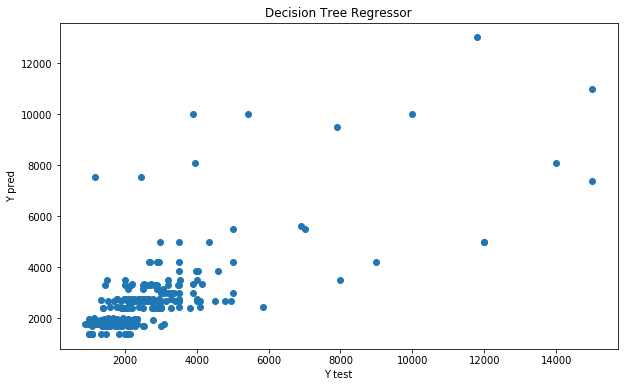

In [107]:
plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_pred_tree)
plt.title('Decision Tree Regressor')
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.show()

## 8.3 - Random Forest Regressor

In [108]:
rf = RandomForestRegressor(random_state = 11, n_estimators = 70)

param_space = {'max_depth': Integer(1, 20),
               'min_samples_split': Real(0.0001, 0.3),
               'max_features': Integer(4, 8)}

bayes_rf = BayesSearchCV(estimator = rf,
                           search_spaces = param_space,
                           n_iter = 50,
                           cv = 3,
                           scoring = 'neg_mean_absolute_error',
                           random_state = 11)

bayes_rf.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=70, n_jobs=None,
                                              oob_score=False,...
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=11,
              refit=True, retur

In [109]:
y_pred_rf = bayes_rf.predict(X_test)
Results['Random Forest Regressor'] = [r2_score(y_test, y_pred_rf), mean_absolute_error(y_test, y_pred_rf)]
print(f'R2 for Random Forest Regressor is: {r2_score(y_test, y_pred_rf):.2}')
print(f'MAE for Random Forest Regressor is: {mean_absolute_error(y_test, y_pred_rf):.5}')

R2 for Random Forest Regressor is: 0.66
MAE for Random Forest Regressor is: 680.77


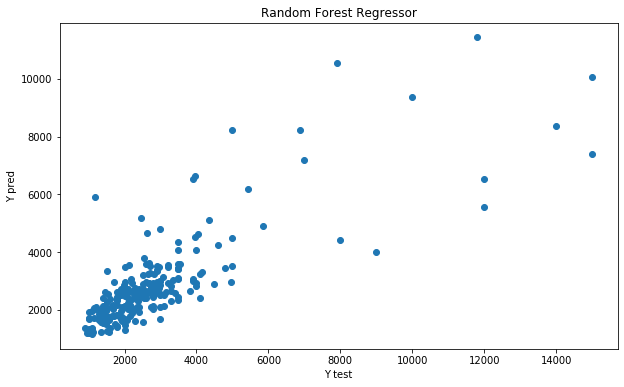

In [110]:
plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_pred_rf)
plt.title('Random Forest Regressor')
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.show()

## 8.4 - Light GBM

In [136]:
gbm = lightgbm.LGBMRegressor()

param_space = {'num_leaves': Integer(2, 100),
               'max_depth': Integer(1, 20),
               'learning_rate': Real(0.01, 0.3),
               'n_estimators': Integer(10, 50),
               'min_split_gain': Real(0.01, 0.3),
               'min_child_samples': Integer(1, 100)}

bayes_gbm = BayesSearchCV(estimator = gbm,
                          search_spaces = param_space,
                          n_iter = 100,
                          scoring = 'neg_mean_absolute_error',
                          cv = 3, 
                          random_state = 11)

bayes_gbm.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent...
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='identity'),
                             'min_child_samples': Integer(low=1, high=100, prior='uniform', transform='identity'),
                             'min_split_gain': Real

In [133]:
bayes_gbm.best_params_

OrderedDict([('learning_rate', 0.11159298071905029),
             ('max_depth', 20),
             ('min_child_samples', 1),
             ('min_split_gain', 0.04061292583695252),
             ('n_estimators', 40),
             ('num_leaves', 26)])

In [139]:
y_pred_gbm = bayes_gbm.predict(X_test)
Results['Light GBM'] = [r2_score(y_test, y_pred_gbm), mean_absolute_error(y_test, y_pred_gbm)]
print(f'R2 for Light GBM Regressor is: {r2_score(y_test, y_pred_gbm):.2}')
print(f'MAE for Light GBM Regressor is: {mean_absolute_error(y_test, y_pred_gbm):.5}')

R2 for Light GBM Regressor is: 0.68
MAE for Light GBM Regressor is: 674.6


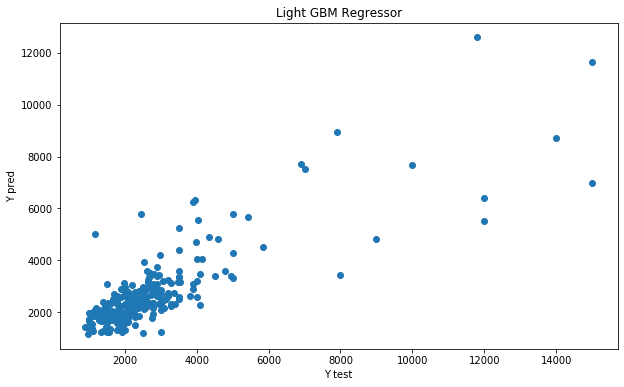

In [140]:
plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_pred_gbm)
plt.title('Light GBM Regressor')
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.show()

## 8.5 - Support Vector Regressor

In [141]:
svr = SVR()

param_space = {'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
               'degree': Integer(1, 7),
               'C': Real(0.001, 200)}

bayes_svr = BayesSearchCV(estimator = svr,
                          search_spaces = param_space,
                          n_iter = 200,
                          scoring = 'neg_mean_absolute_error',
                          cv = 3, 
                          random_state = 11)

bayes_svr.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                            epsilon=0.1, gamma='scale', kernel='rbf',
                            max_iter=-1, shrinking=True, tol=0.001,
                            verbose=False),
              fit_params=None, iid=True, n_iter=200, n_jobs=1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=11,
              refit=True, return_train_score=False,
              scoring='neg_mean_absolute_error',
              search_spaces={'C': Real(low=0.001, high=200, prior='uniform', transform='identity'),
                             'degree': Integer(low=1, high=7, prior='uniform', transform='identity'),
                             'kernel': Categorical(categories=('linear', 'poly', 'rbf', 'sigmoid'), prior=None)},
              verbose=0)

In [142]:
bayes_svr.best_params_

OrderedDict([('C', 86.59143931835297), ('degree', 2), ('kernel', 'poly')])

In [143]:
y_pred_bayes_svr = bayes_svr.predict(X_test)
Results['SVR'] = [r2_score(y_test, y_pred_bayes_svr), mean_absolute_error(y_test, y_pred_bayes_svr)]
print(f'R2 for Light SVR is: {r2_score(y_test, y_pred_bayes_svr):.2}')
print(f'MAE for Light SVR is: {mean_absolute_error(y_test, y_pred_bayes_svr):.5}')

R2 for Light SVR is: 0.67
MAE for Light SVR is: 710.15


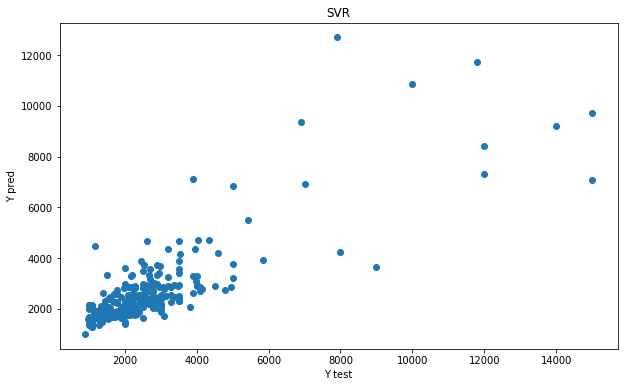

In [144]:
plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_pred_bayes_svr)
plt.title('SVR')
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.show()

## 8.6 - Neural Network

In [146]:
minmax_2 = MinMaxScaler()

y_train_mlp = minmax_2.fit_transform(y_train.values.reshape(-1,1))
y_test_mlp = minmax_2.transform(y_test.values.reshape(-1,1))

In [167]:
mlp = Sequential()

mlp.add(Dense(800, input_dim = 8, activation = 'relu')) 
mlp.add(Dropout(0.2))
mlp.add(Dense(800, activation = 'sigmoid'))
mlp.add(Dropout(0.2))
mlp.add(Dense(800, activation = 'tanh'))
mlp.add(Dropout(0.1))
mlp.add(Dense(1))

mlp.compile(loss = 'mean_absolute_error', optimizer = 'adam')

In [168]:
es = EarlyStopping(min_delta = 0.0001, patience = 10, restore_best_weights = True)
mlp.fit(X_train, y_train_mlp, epochs = 1000, validation_split = 0.1, callbacks = [es])

Epoch 1/1000
29/29 [==============================] - 0s 14ms/step - loss: 1.4005 - val_loss: 0.0885
Epoch 2/1000
29/29 [==============================] - 0s 12ms/step - loss: 0.3313 - val_loss: 0.4459
Epoch 3/1000
29/29 [==============================] - 0s 12ms/step - loss: 0.3617 - val_loss: 0.5564
Epoch 4/1000
29/29 [==============================] - 0s 12ms/step - loss: 0.4222 - val_loss: 0.3237
Epoch 5/1000
29/29 [==============================] - 0s 12ms/step - loss: 0.3314 - val_loss: 0.2306
Epoch 6/1000
29/29 [==============================] - 0s 13ms/step - loss: 0.4014 - val_loss: 0.1785
Epoch 7/1000
29/29 [==============================] - 0s 12ms/step - loss: 0.3176 - val_loss: 0.0503
Epoch 8/1000
29/29 [==============================] - 0s 12ms/step - loss: 0.2905 - val_loss: 0.1144
Epoch 9/1000
29/29 [==============================] - 0s 12ms/step - loss: 0.2751 - val_loss: 0.1722
Epoch 10/1000
29/29 [==============================] - 0s 13ms/step - loss: 0.2828 - val_lo

In [179]:
y_pred_mlp = mlp.predict(X_test)
Results['MLP'] = [r2_score(y_test_mlp, y_pred_mlp), mean_absolute_error(minmax_2.inverse_transform(y_test_mlp), minmax_2.inverse_transform(y_pred_mlp))]
print(f'R2 for MLP is: {r2_score(y_test_mlp, y_pred_mlp):.2}')
print(f'MAE for MLP is: {mean_absolute_error(minmax_2.inverse_transform(y_test_mlp), minmax_2.inverse_transform(y_pred_mlp)):.5}')

R2 for MLP is: 0.56
MAE for MLP is: 806.3


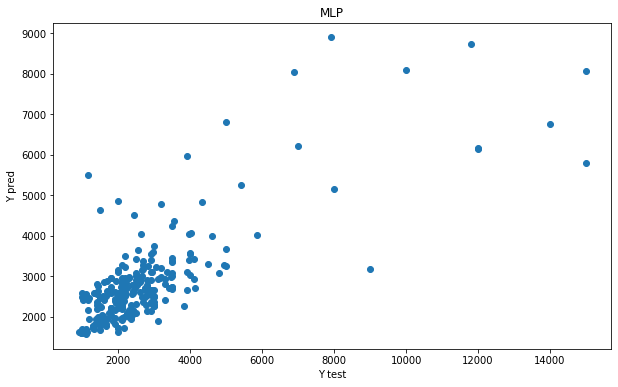

In [180]:
plt.figure(figsize = (10, 6))
plt.scatter(minmax_2.inverse_transform(y_test_mlp), minmax_2.inverse_transform(y_pred_mlp))
plt.title('MLP')
plt.xlabel('Y test')
plt.ylabel('Y pred')
plt.show()

# 9 - Results and Final Comments

In [181]:
results = pd.DataFrame(Results)
results = results.T
results

,0,1
Linear_Regression,0.634459,771.083161
Decision Tree Regressor,0.520313,808.109044
Random Forest Regressor,0.655123,680.770714
Light GBM,0.679523,674.596856
SVR,0.673338,710.149367
MLP,0.564741,806.296462


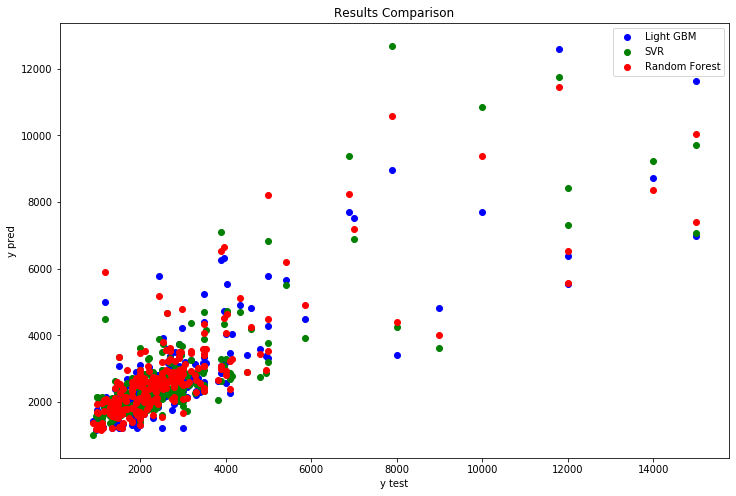

In [184]:
plt.figure(figsize = (12, 8))
plt.scatter(y_test, y_pred_gbm, color = 'blue', label = 'Light GBM')
plt.scatter(y_test, y_pred_bayes_svr, color = 'green', label = 'SVR')
plt.scatter(y_test, y_pred_rf, color = 'red', label = 'Random Forest')
plt.legend()
plt.title('Results Comparison')
plt.xlabel('y test')
plt.ylabel('y pred');

Based on previously analysis the best model to predict apartment rental price in SP is Light GBM Regressor. However a lot of improvements can be done on this model. There are some features that might have a very high effect on rental price like apartment year built and how long the apartment is being exposed in the website. New apartments tends to have a higher rental price than old ones, and as long as the apartment is being exposed without anyone interested in it, the owner tends to decrease the value in order to find someone to rent the apartment.